
# Lab 2 — Simulation of Random Variables (Probabilistic Programming)

This notebook contains a **reference implementation** for the two exercises in Lab 2:

- **Exercise 1** – Urn experiment with a die-driven update and a single draw.
- **Exercise 2** – Poisson simulations for fixed rates and a **mixture of Poissons**, including a short discussion about **overdispersion** and a **weighted-mixture bonus**.

Reproducibility is ensured using `numpy.random.default_rng` with fixed seeds in each experiment.


In [1]:

# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set global plotting defaults for readability (no specific colors)
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = True

def show_table(df):
    try:
        from IPython.display import display
        display(df)
    except Exception:
        print(df)



## Exercise 1 — Urn with die update and one draw

**Initial urn:** 3 red (R), 4 blue (B), 2 black (K).  
Roll one fair die and update the urn as follows **before** drawing one ball:
- If die is prime (**2, 3, 5**) → add **black**
- If die is **6** → add **red**
- Otherwise (**1 or 4**) → add **blue**

Then **draw one ball** uniformly at random from the updated urn. Estimate \(\mathbb{P}(\text{red})\) via Monte‑Carlo and compare with theory.


In [2]:

from typing import Tuple

def roll_die(rng: np.random.Generator) -> int:
    return int(rng.integers(1, 7))

def roll_and_update_counts(r_init=3, b_init=4, k_init=2, rng: np.random.Generator | None = None) -> Tuple[int, int, int]:
    if rng is None:
        rng = np.random.default_rng(42)
    r, b, k = r_init, b_init, k_init
    d = roll_die(rng)
    if d in (2, 3, 5):      # prime -> add black
        k += 1
    elif d == 6:            # six -> add red
        r += 1
    else:                   # otherwise -> add blue (1 or 4)
        b += 1
    return r, b, k

def draw_from_urn(r: int, b: int, k: int, rng: np.random.Generator | None = None) -> str:
    if rng is None:
        rng = np.random.default_rng(42)
    total = r + b + k
    x = int(rng.integers(0, total))
    if x < r:
        return "red"
    elif x < r + b:
        return "blue"
    else:
        return "black"

def simulate_urn(n_trials: int = 200_000, r_init=3, b_init=4, k_init=2, seed: int = 123) -> float:
    rng = np.random.default_rng(seed)
    reds = 0
    for _ in range(n_trials):
        r, b, k = roll_and_update_counts(r_init, b_init, k_init, rng)
        if draw_from_urn(r, b, k, rng) == "red":
            reds += 1
    return reds / n_trials

def theoretical_prob_red_urn() -> float:
    # P(prime)=1/2 -> updated urn (3,4,3) -> P(red)=3/10
    # P(6)=1/6     -> updated urn (4,4,2) -> P(red)=4/10
    # P(other)=1/3 -> updated urn (3,5,2) -> P(red)=3/10
    # Total = (1/2)*(3/10) + (1/6)*(4/10) + (1/3)*(3/10) = 19/60
    return 19/60

est_red = simulate_urn(n_trials=200_000, seed=123)
theo_red = theoretical_prob_red_urn()

print(f"Estimated P(red): {est_red:.6f}")
print(f"Theoretical P(red): {theo_red:.6f}")
print(f"Absolute error: {abs(est_red - theo_red):.6f}")


Estimated P(red): 0.315235
Theoretical P(red): 0.316667
Absolute error: 0.001432



## Exercise 2 — Poisson simulations and a mixture

1. Generate five datasets of size \(n=1000\): four **fixed** Poisson(\(\lambda\)) with \(\lambda \in \{1,2,5,10\}\), and one **mixture** where for **each sample** you first pick \(\lambda\) uniformly from \(\{1,2,5,10\}\) then draw a Poisson(\(\lambda\)).  
2. Plot histograms for all datasets (one figure per dataset).  
3. Compare **mean** and **variance**. For fixed Poisson, \(\mathbb{Var}[X]\approx\mathbb{E}[X]=\lambda\). For the **mixture**, if \(\Lambda\) is random, then
\[
\mathbb{E}[X] = \mathbb{E}[\Lambda], \quad
\mathbb{Var}[X] = \mathbb{E}[\Lambda] + \operatorname{Var}(\Lambda)\,,
\]
often leading to **overdispersion** (variance > mean).


In [3]:

def simulate_poisson(lam: float, n: int = 1_000, seed: int | None = None) -> np.ndarray:
    rng = np.random.default_rng(seed)
    return rng.poisson(lam=lam, size=n)

def simulate_poisson_mixture(lambdas, probs=None, n: int = 1_000, seed: int | None = None):
    lambdas = np.array(lambdas, dtype=float)
    if probs is None:
        probs = np.ones_like(lambdas) / len(lambdas)
    probs = np.array(probs, dtype=float)
    probs = probs / probs.sum()

    rng = np.random.default_rng(seed)
    idx = rng.choice(len(lambdas), size=n, p=probs)
    chosen = lambdas[idx]
    samples = rng.poisson(lam=chosen)
    return samples, chosen

def summarize(arr: np.ndarray, name: str) -> dict:
    return {
        "dataset": name,
        "n": len(arr),
        "mean": float(np.mean(arr)),
        "variance": float(np.var(arr, ddof=0)),
        "min": int(np.min(arr)),
        "max": int(np.max(arr)),
    }

LAMBDAS = [1, 2, 5, 10]
X1 = simulate_poisson(1, n=1_000, seed=101)
X2 = simulate_poisson(2, n=1_000, seed=102)
X3 = simulate_poisson(5, n=1_000, seed=103)
X4 = simulate_poisson(10, n=1_000, seed=104)
Xmix, chosen_lams = simulate_poisson_mixture(LAMBDAS, n=1_000, seed=105)

rows = [
    summarize(X1, "Poisson(1)"),
    summarize(X2, "Poisson(2)"),
    summarize(X3, "Poisson(5)"),
    summarize(X4, "Poisson(10)"),
    summarize(Xmix, "Mixture (uniform λ∈{1,2,5,10})"),
]
df_stats = pd.DataFrame(rows)
show_table(df_stats)


,dataset,n,mean,variance,min,max
0,Poisson(1),1000,0.969,1.000039,0,6
1,Poisson(2),1000,1.985,2.188775,0,8
2,Poisson(5),1000,5.037,5.081631,0,16
3,Poisson(10),1000,9.910,9.859900,1,20
4,"Mixture (uniform λ∈{1,2,5,10})",1000,4.299,16.041599,0,21


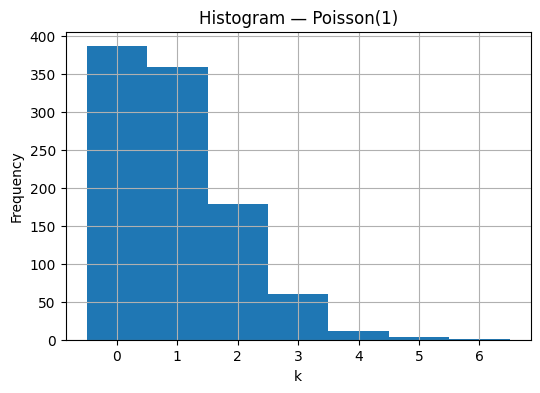

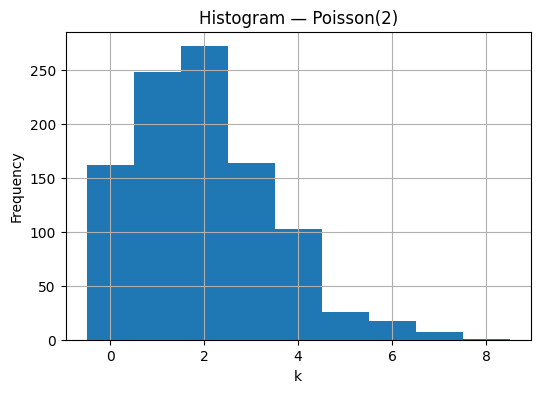

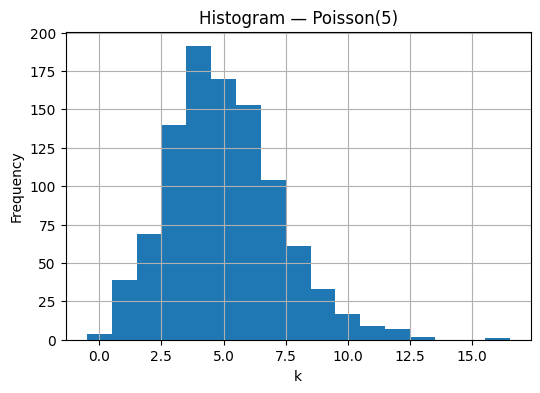

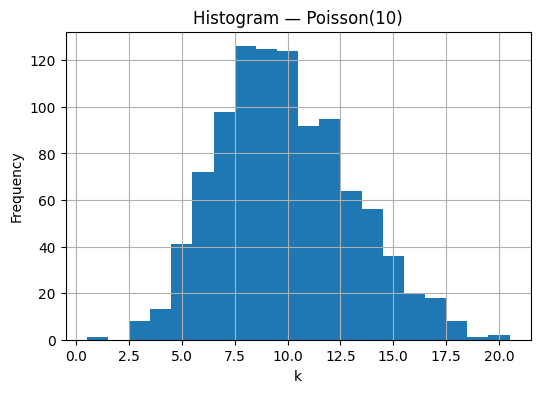

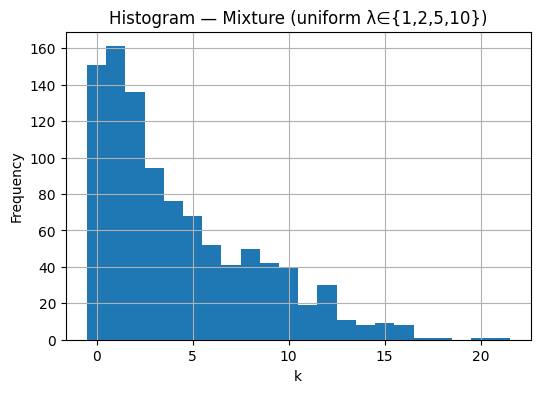

In [4]:

def plot_hist(data: np.ndarray, title: str):
    plt.figure()
    bins = range(int(data.min()), int(data.max()) + 2)  # integer-aligned bins
    plt.hist(data, bins=bins, align='left')
    plt.title(title)
    plt.xlabel("k")
    plt.ylabel("Frequency")
    plt.show()

plot_hist(X1, "Histogram — Poisson(1)")
plot_hist(X2, "Histogram — Poisson(2)")
plot_hist(X3, "Histogram — Poisson(5)")
plot_hist(X4, "Histogram — Poisson(10)")
plot_hist(Xmix, "Histogram — Mixture (uniform λ∈{1,2,5,10})")



### Discussion (short)

- Each fixed Poisson shows **Var ≈ Mean = λ**.  
- The **mixture** shows **Var = E[Λ] + Var(Λ)** with Λ uniform on {1,2,5,10}, hence **overdispersion** (variance > mean).  
- This phenomenon appears in practice when the rate parameter is uncertain or heterogeneous across sub-populations.



### Bonus — Weighted mixture

Make \(\lambda=5\) more likely (e.g., probabilities `[0.1, 0.1, 0.6, 0.2]`) and observe how the histogram and summary shift.


,dataset,n,mean,variance,min,max
0,Mixture (weighted; λ=5 more likely),1000,5.286,12.350204,0,18


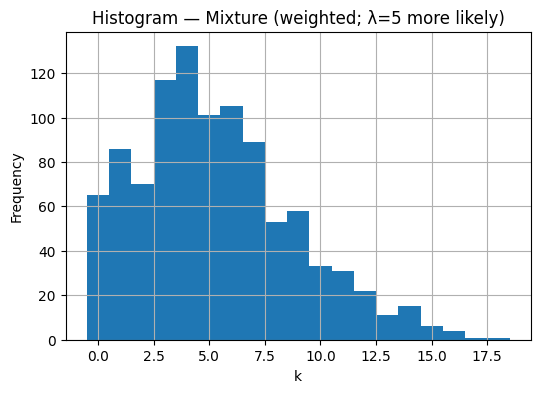

In [5]:

weighted_probs = np.array([0.1, 0.1, 0.6, 0.2], dtype=float)
Xmix_w, chosen_w = simulate_poisson_mixture(LAMBDAS, probs=weighted_probs, n=1_000, seed=106)

df_w = pd.DataFrame([
    summarize(Xmix_w, "Mixture (weighted; λ=5 more likely)")
])
show_table(df_w)
plot_hist(Xmix_w, "Histogram — Mixture (weighted; λ=5 more likely)")



---

## Rubric snapshot (for instructors)

- **Exercise 1 (1p + 0.5p bonus)**: correct die logic & simulation (0.5p), Monte‑Carlo estimate and commentary (0.5p), **bonus** exact probability 19/60 and comparison (0.5p).
- **Exercise 2 (2p + 0.5p bonus)**: fixed Poisson datasets (0.5p), randomized mixture (0.5p), five histograms saved or shown (0.5p), mean/variance comparison & overdispersion remark (0.5p), **bonus** weighted mixture + comment (0.5p).
- **Presentation/Repro (−0.3 max deductions)**: seeds, structure, clear outputs.

*Tip:* On the mixture, watch for the common mistake of sampling **one** λ and reusing it for all n samples (should be one λ **per sample**).


In [6]:

# Environment info (optional)
import sys
print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", plt.matplotlib.__version__)


Python: 3.11.2
NumPy: 2.3.5
Pandas: 2.3.3
Matplotlib: 3.10.8
